In [1]:
import xarray as xr
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 
import tqdm

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='08:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

<Client: 'tcp://172.18.4.22:39521' processes=0 threads=0, memory=0 B>

In [10]:
ds = xr.open_zarr('data2/level2/retry_with_time_parcels_releases_seed-123.zarr',chunks='auto') 

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days

In [56]:
ds.age

<xarray.DataArray 'age' (trajectory: 986500, time: 10013)>
dask.array<open_dataset-age, shape=(986500, 10013), dtype=float32, chunksize=(500, 601), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Attributes:
    long_name:      
    standard_name:  age
    units:          unknown

In [57]:
mask = ds.age*np.timedelta64(1, 'h') <= np.timedelta64(30, 'D')

In [59]:
ds_slice_mask = ds.where(mask, drop=False)

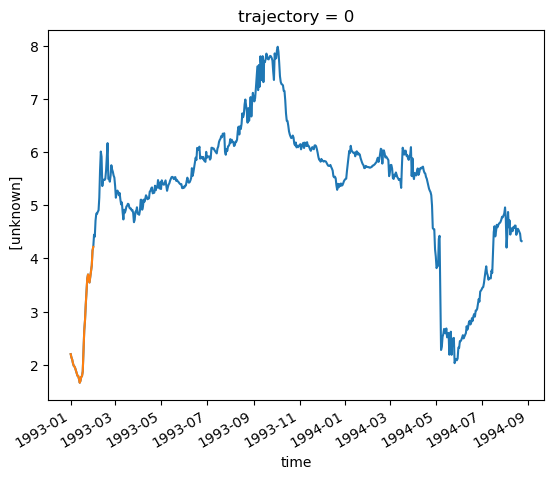

In [61]:
ds.isel(trajectory=0).temp.plot()
ds_slice_mask.isel(trajectory=0).temp.plot()


In [62]:
ds_slice_mask

<xarray.Dataset>
Dimensions:     (trajectory: 986500, time: 10013)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [29]:
ds_sliced = ds.where((ds.age*hours_to_months) < 1,drop=False)

In [27]:
#ds_sliced.dropna(dim='time')

In [30]:
particles_younger_1_month  = (ds.age*hours_to_months < 1).any(dim='time')

particles_older_1_month = ~particles_younger_1_month

# Filter the dataset to include only particles that have not reached zero salinity
ds_filtered = ds.where(particles_older_1_month.compute(), drop=True)

In [68]:
ds.isel(trajectory=0).temp.compute().data

array([2.2011974, 2.1382933, 2.0984335, ...,       nan,       nan,
             nan], dtype=float32)

In [69]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 986500, time: 10013)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

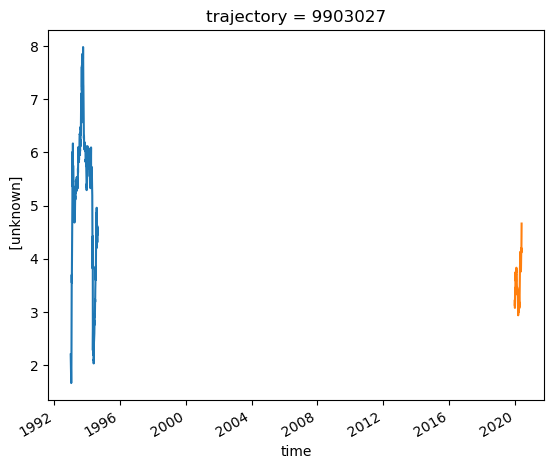

In [67]:
ds.isel(trajectory=0).temp.plot()
ds.isel(trajectory=-1).temp.plot()

In [39]:
ds_sel = ds_sliced.sel(time=pd.date_range("1993-01-01","2019-12-31", freq="1D"), method="nearest")
ds_sel

<xarray.Dataset>
Dimensions:     (trajectory: 986500, time: 9861)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(500, 601), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(500, 601), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [63]:
#ds_sel.time[:10]

In [45]:

ds_sel = ds.sel(time=pd.date_range("1993-01-01","2019-12-31", freq="1D"), method="nearest")


positions_w_var = {}

for i in tqdm.tqdm(ds_sel.time[:10]):
    positions_w_var[i.dt.strftime('%Y-%m-%d %H:%M:%S').item(0)] = {
        'lat': ds_sliced.lat.sel(time=i).values,
        'lon': ds_sliced.lon.sel(time=i).values,
        'z': ds_sliced.z.sel(time=i).values,
        'salt': ds_sliced.salt.isel(time=0).values,
        'temp': ds_sliced.temp.isel(time=0).values
    }



100%|██████████| 10/10 [02:32<00:00, 15.24s/it]


In [46]:
import pandas as pd

df = pd.DataFrame(positions_w_var).T

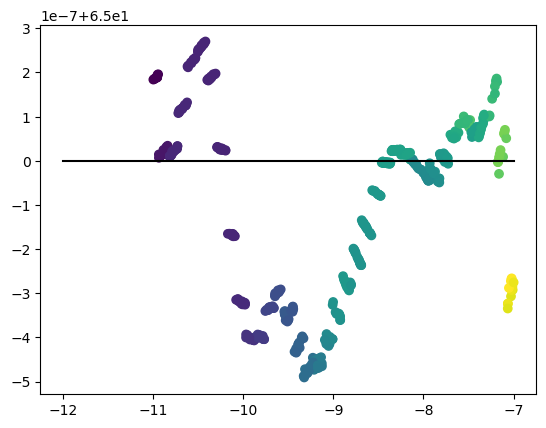

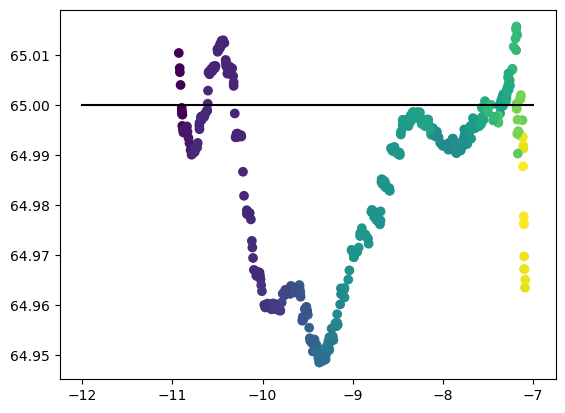

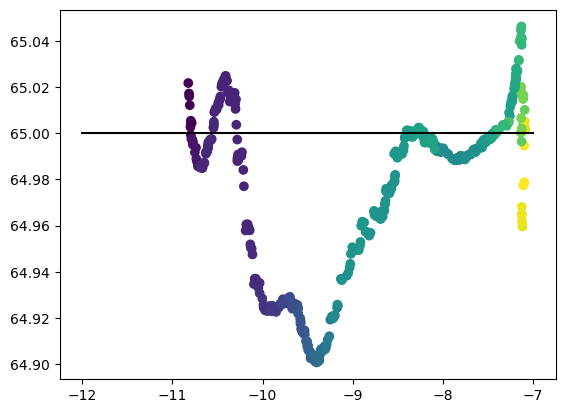

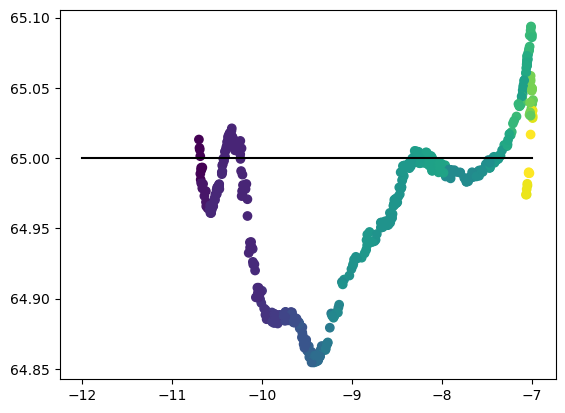

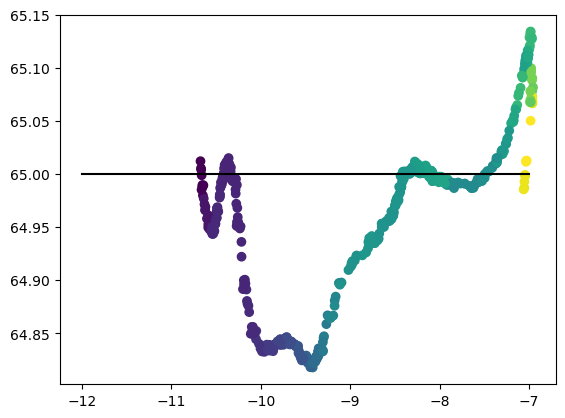

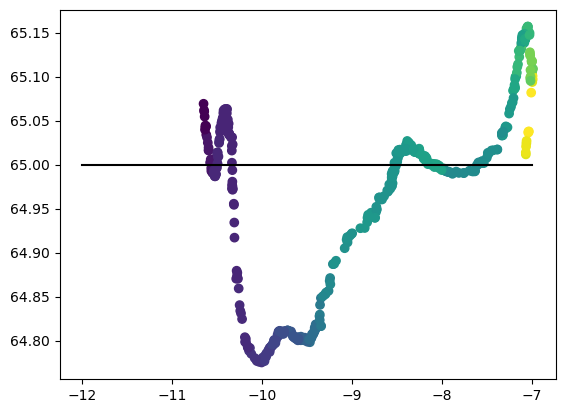

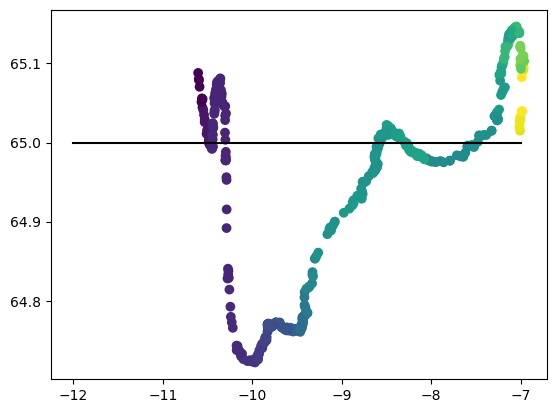

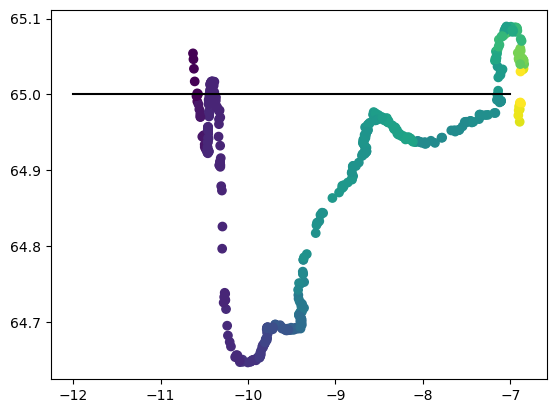

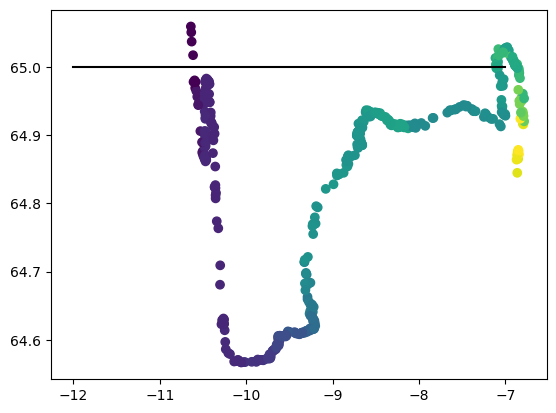

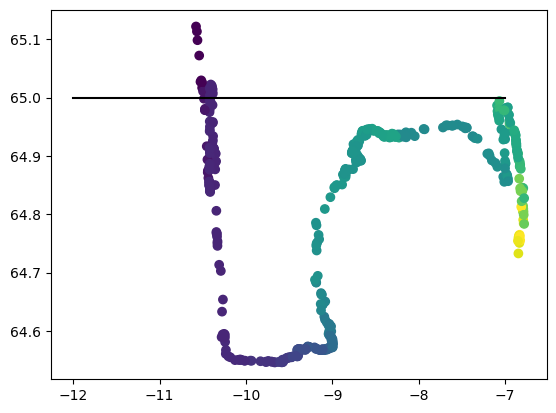

In [52]:
for i in range(df.lat.size):
    plt.scatter(df.lon[i],df.lat[i],c=df.salt[i])
    plt.plot([-7,-12],[65,65],color='k')
    plt.show()


In [49]:
df.lat.size

10

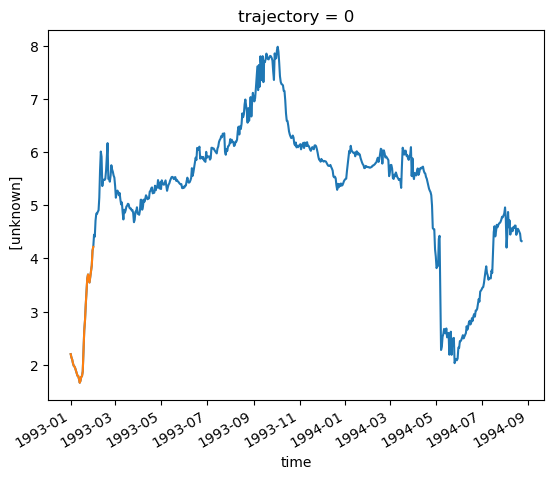

In [23]:
ds.isel(trajectory=0).temp.plot()
ds_sliced.isel(trajectory=0).temp.plot()
plt.show()

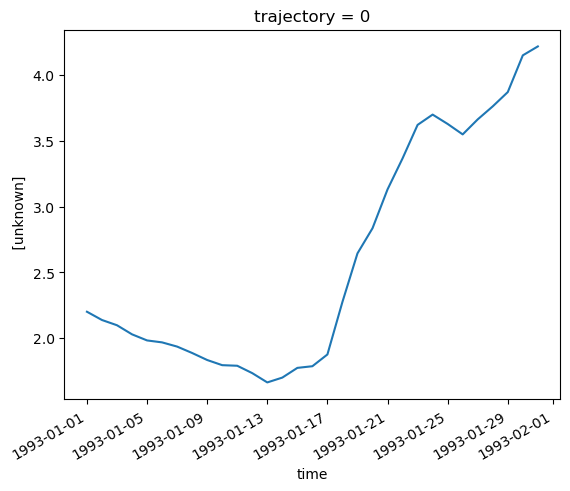

In [7]:
ds.isel(trajectory=0).temp.plot();

In [ ]:
ds

In [3]:
#pd.to_datetime(ds["time"].isel(trajectory=0, obs=0).values).floor("H")

In [4]:
#ds_whole = xr.open_zarr('data2/level2/parcels_releases_seed-123_iceland.zarr')

In [5]:
#pd.to_datetime(ds["time"].isel(trajectory=-40, obs=-1).values).floor("H")

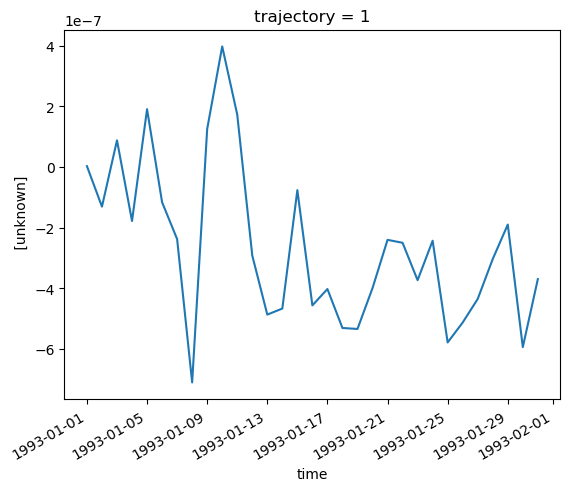

In [5]:
ds_slice_age.isel(trajectory=1).vvel.plot();

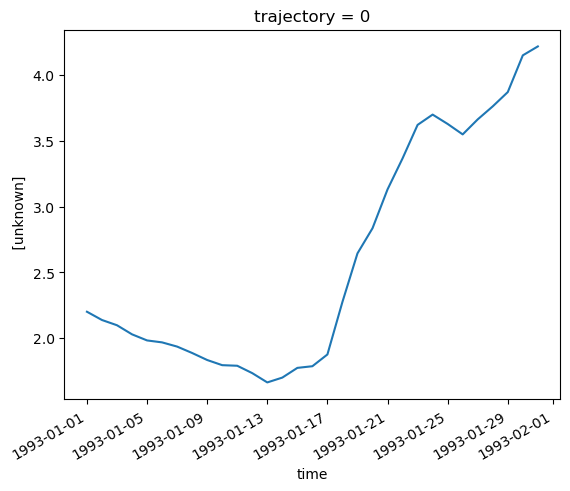

In [ ]:
nans = ds_slice_age['temp'].isnull().sum(dim='obs').compute()

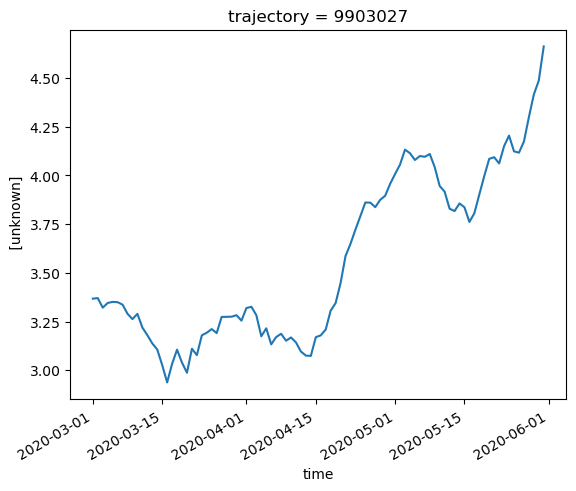

In [41]:
ds.where((ds.age*hours_to_months) > 2,drop=False).isel(trajectory=-1).temp.plot()

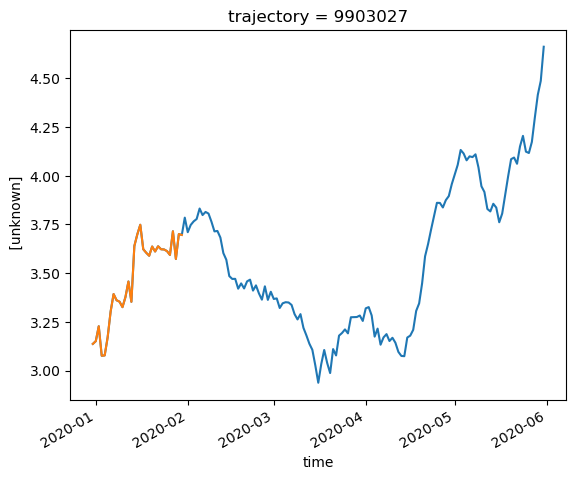

In [73]:
ds.isel(trajectory=-1).temp.plot()
ds.where((ds.age*hours_to_months) < 1,drop=False).isel(trajectory=-1).temp.plot()



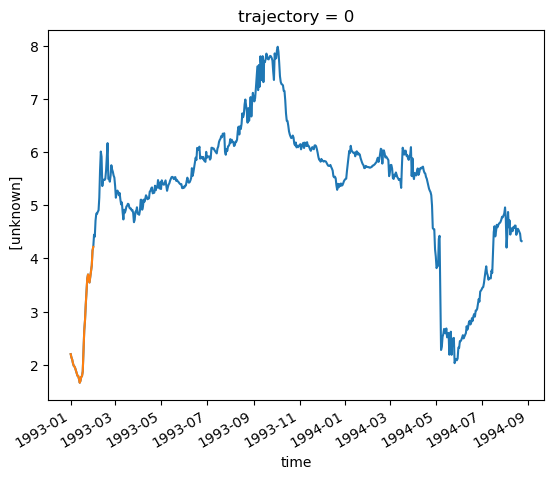

In [58]:
ds.isel(trajectory=0).temp.plot()
ds.where((ds.age*hours_to_months) < 1,drop=False).isel(trajectory=0).temp.plot()



In [36]:
(ds.age*hours_to_months).isel(trajectory=-1).min().values

array(0.00022869, dtype=float32)

In [ ]:
ds_dropnans = ds.where(ds.age*hours_)

In [100]:
from datetime import timedelta, datetime

# outputdt = np.timedelta64(24, 'h')

# # Remove NaT values from the time array
# valid_times = ds["time"].values#[np.isfinite(ds["time"].values)]

# # timerange in datetime64[ns]
# timerange = np.arange(
#     np.nanmin(valid_times).astype('datetime64[ns]'),
#     np.nanmax(valid_times).astype('datetime64[ns]') + outputdt,
#     outputdt,
# )

# t = str(timerange[0].astype("timedelta64[h]"))

# time_id = np.where(ds["time"] == t)
# # Adjust t to get the correct time in the year 2018
# t = timerange.astype("datetime64[h]")

# # Find the indices where the time matches the timerange
# time_id = [np.where(ds["time"] == time_point) for time_point in t]

outputdt = np.timedelta64(12, 'h')

# timerange in datetime64[ns]
timerange = np.arange(
    np.nanmin(ds["time"].values),
    np.nanmax(ds["time"].values) + outputdt,
    outputdt,
)

t = str(timerange[0].astype("timedelta64[h]"))

time_id = np.where(ds["time"] == t)
# Adjust t to get the correct time in the year 2018
t = timerange.astype("datetime64[h]")

# Find the indices where the time matches the timerange
time_id = [np.where(ds["time"] == time_point) for time_point in t]

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('float64') and dtype('<m8[h]')

In [128]:
time_vals = ds.time.values

In [129]:
outputdt = np.timedelta64(12, 'h')


In [130]:
timerange = np.arange(
    np.nanmin(time_vals).astype('datetime64[ns]'),
    np.nanmax(time_vals).astype('datetime64[ns]') + outputdt,
    outputdt,
)


In [131]:
t = str(timerange[0].astype("timedelta64[h]"))

In [134]:
timerange.shape

(19769,)

In [135]:

time_id = np.where(ds["time"] == t)

t = timerange.astype("datetime64[h]")

# Find the indices where the time matches the timerange
time_id = [np.where(ds["time"] == time_point) for time_point in t]

KeyboardInterrupt: 

In [67]:
timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])


In [85]:
lat_vals = ds["lat"].values

In [86]:
lon_vals = ds["lon"].values

In [91]:
t = str(timerange[0].astype("timedelta64[h]"))

In [90]:
t

'1581984001000000000 hours'

In [78]:
np.arange(0,ds.trajectory.size,1_000).shape

(987,)

100%|██████████| 987/987 [00:03<00:00, 302.66it/s]


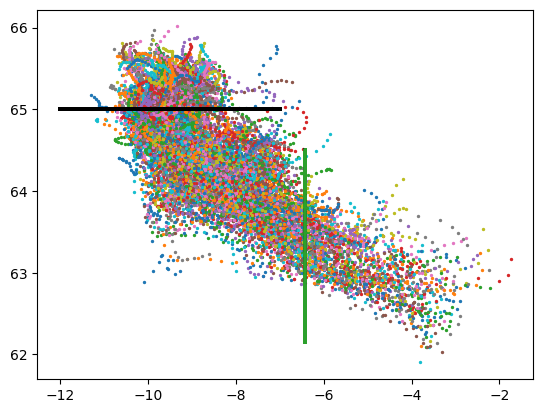

In [87]:
for i in tqdm.tqdm(np.arange(0,ds.trajectory.size,1_000)):
    plt.scatter(lon_vals[i],lat_vals[i],s=2)
    plt.plot([-7,-12],[65,65],color='k')
    plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section')
plt.show()

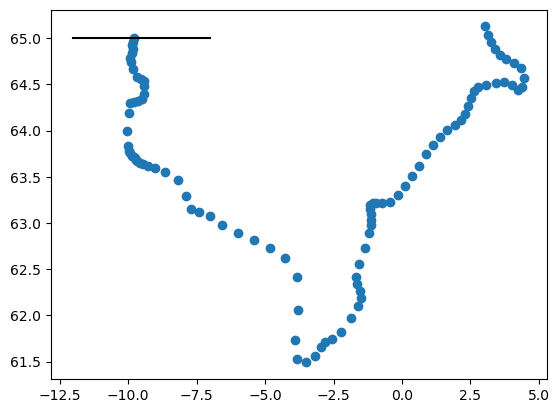

In [39]:
plt.scatter(ds["lon"].values[0], ds["lat"].values[0])
plt.plot([-7,-12],[65,65],color='k')
plt.show()

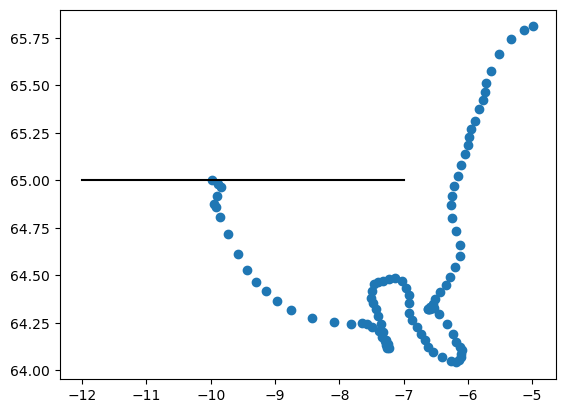

In [40]:
plt.scatter(ds["lon"].values[-1], ds["lat"].values[-1])
plt.plot([-7,-12],[65,65],color='k')
plt.show()

In [74]:
#ds.isel(trajectory=0).temp.isel(obs=slice(0,200)).plot()
ds.isel(trajectory=-1).temp.isel(obs=slice(0,100)).values

array([3.1366923, 3.150929 , 3.2273066, 3.07586  , 3.0777054, 3.1708696,
       3.3026845, 3.3926954, 3.360837 , 3.3534513, 3.3254032, 3.3772101,
       3.4570653, 3.3527853, 3.6392708, 3.6990771, 3.7483132, 3.6227174,
       3.6046205, 3.58924  , 3.636696 , 3.6110387, 3.6379554, 3.622498 ,
       3.6215117, 3.6130824, 3.5933738, 3.7148638, 3.5727062, 3.700742 ,
       3.6958117, 3.7849395, 3.7101955, 3.747359 , 3.765728 , 3.7778432,
       3.831609 , 3.7980688, 3.814106 , 3.805668 , 3.7635236, 3.714222 ,
       3.716491 , 3.6826243, 3.602785 , 3.5687163, 3.484876 , 3.4702091,
       3.4707239, 3.4202375, 3.447368 , 3.4213524, 3.4577744, 3.4666107,
       3.4104066, 3.4371324, 3.3958123, 3.3638968, 3.4323554, 3.3627434,
       3.4043968, 3.367439 , 3.3702803, 3.3210855, 3.345231 , 3.3508093,
       3.3492627, 3.336725 , 3.2897587, 3.26239  , 3.289537 , 3.2191234,
       3.1802955, 3.1376855, 3.1064775, 3.0265453, 2.9374475, 3.0329576,
       3.105529 , 3.0388687, 2.9871142, 3.110196 , 

In [122]:
from glob import glob
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/iceland_expt/data2/"
level1_files = sorted(glob(inpath + "level1/parcels_releases_seed-123_*.zarr"))
print(f"{len(level1_files)} found")
global trj_idx
trj_idx = 0

frequency = "24H"

#entire_times = pd.date_range(start="1993-01-01", end="2020-05-31", freq=frequency)

entire_times = pd.date_range(start="1993-01-01", end="2020-05-31", freq=frequency)


def preprocess(ds):
    """
    The trajecetories in each dataset start with 0, to make them compatible
    we add the last trajectory index to each trajectory.
    """
    global trj_idx
    trj_number = max(ds["trajectory"])
    ds["trajectory"] = ds["trajectory"] + trj_idx
    ds = ds.isel(obs=slice(0, 100))  # Select the first 100 observations
    start_time = pd.to_datetime(ds["time"].isel(trajectory=0, obs=0).values).floor("H")
    freq = frequency
    time = pd.date_range(start=start_time, periods=len(ds["obs"]), freq=freq)
    ds["obs"] = time
    del ds["time"]
    ds = ds.rename({"obs": "time"})
    ds = ds.reindex(time=entire_times)
    trj_idx = trj_idx + trj_number
    return ds


1973 found


In [ ]:
# load in snapshot velocity and mesh masks

U_snapshot = xr.open_dataset('../../Data/U/U_velocity_2010-06-30.nc')
V_snapshot = xr.open_dataset('../../Data/V/V_velocity_2010-06-30.nc')

m = 1#650
U_m = U_snapshot.vozocrtx.isel(time_counter=0).sel(deptht=m,method='nearest')
V_m = V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=m,method='nearest')

speed_m = (U_m**2 + V_m**2)**.5

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point 
bathymetry = (z*t_mask).isel(t=0).sum(dim='z')

# turn zeros into nans, easier to see where continents are 
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

In [125]:
# Split level1_files into several sublists for parallel processing
file = level1_files[-1]
ds = xr.open_dataset(file, engine="zarr")
ds = preprocess(ds)


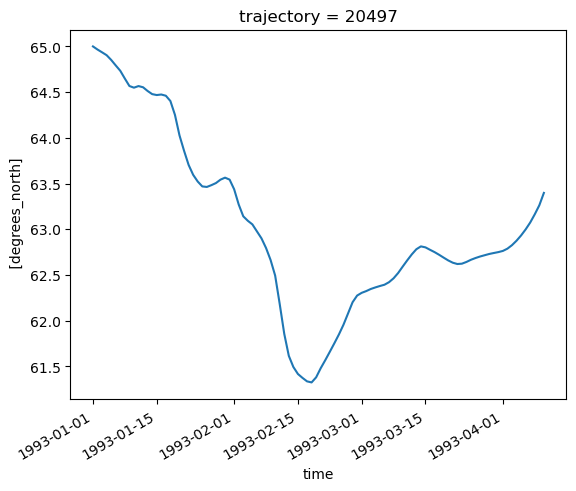

In [129]:
ds.isel(trajectory=-1).lat.plot()

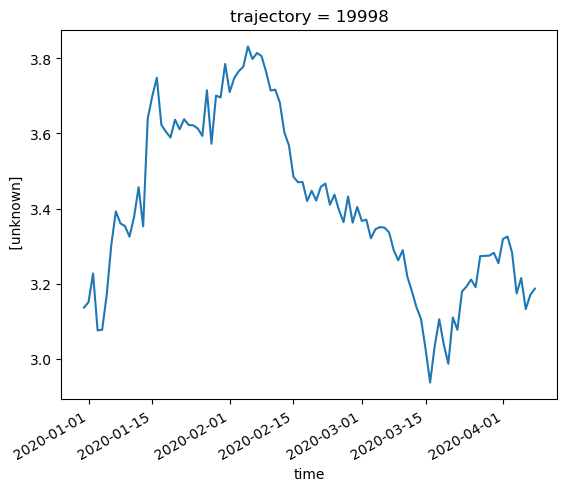

In [127]:
ds.isel(trajectory=-1).temp.plot()

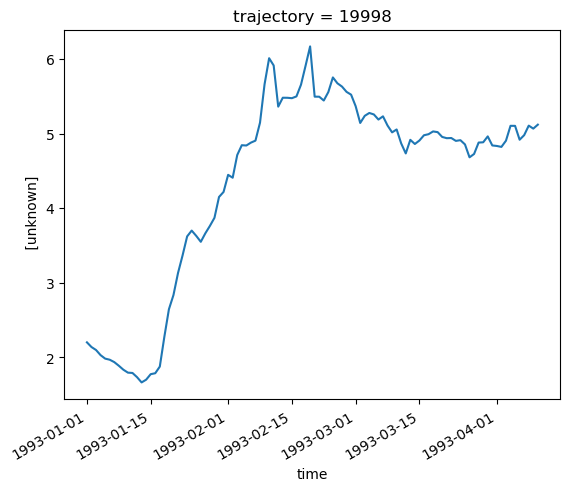

In [128]:
# Split level1_files into several sublists for parallel processing
file = level1_files[0]
ds = xr.open_dataset(file, engine="zarr")
ds = preprocess(ds)

ds.isel(trajectory=0).temp.plot()

In [76]:
# ds_w_time.isel(trajectory=0).temp.isel(time=slice(0,100)).plot()
# #ds_w_time.isel(trajectory=-1).temp.plot()

In [2]:

import xarray as xr
ds_w_time = xr.open_zarr('data2/level3-2/slice_with_time_parcels_releases_seed-123.zarr',chunks='auto') 

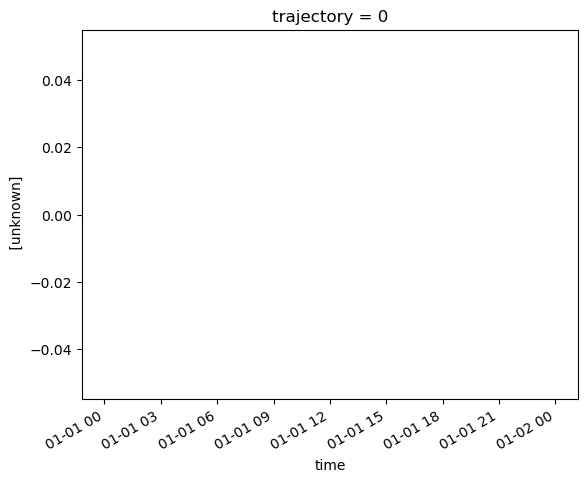

In [111]:
ds_w_time.isel(trajectory=0).temp.plot();

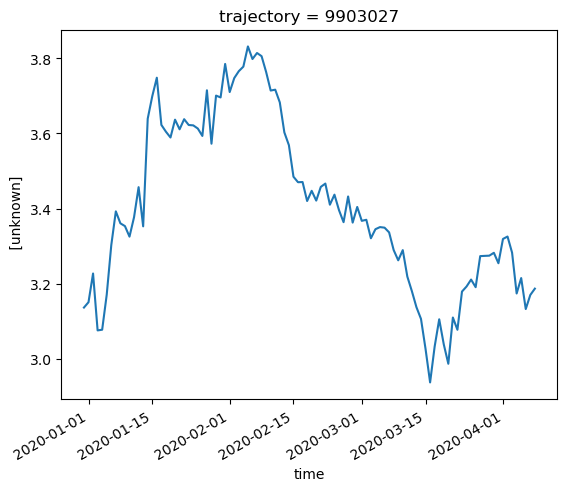

In [114]:
ds_w_time.isel(trajectory=-1).temp.plot();

In [2]:
## THIS WORKS
import xarray as xr

ds = xr.open_mfdataset(
    '/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/iceland_expt/data2/level3/slice_with_time_parcels_releases_seed-123_0*.zarr',
    engine="zarr",
    combine="nested",
    concat_dim="trajectory",
)

In [9]:
ds_test = xr.open_zarr('data2/level3/slice_with_time_parcels_releases_seed-123.zarr',chunks='auto')

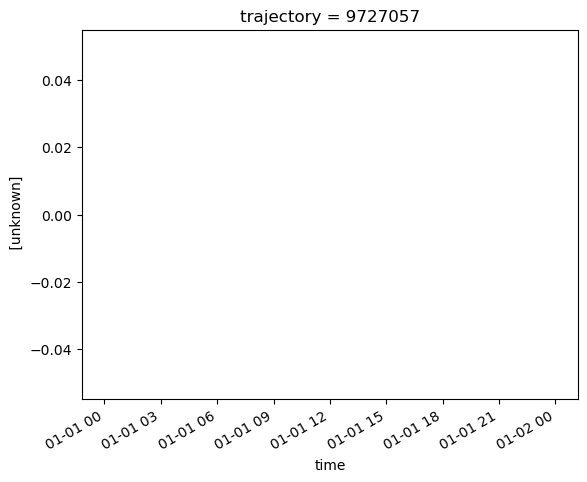

In [14]:
ds_test.isel(trajectory=-15000).temp.plot();

In [3]:
ds = xr.open_mfdataset(
    '/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/iceland_expt/data2/level3-2/slice_with_time_parcels_releases_seed-123_0*.zarr',
    engine="zarr",
    combine="nested",
    concat_dim="trajectory",
)



In [3]:
# Saving the rechunked output
for var in ds.data_vars:
    del ds[var].encoding["chunks"]
    del ds[var].encoding['preferred_chunks']

In [4]:
ds = ds.chunk({'trajectory':500, 'time': 600})

In [5]:
ds.lat

<xarray.DataArray 'lat' (trajectory: 986500, time: 10013)>
dask.array<rechunk-merge, shape=(986500, 10013), dtype=float64, chunksize=(500, 600), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Attributes:
    axis:           Y
    long_name:      
    standard_name:  latitude
    units:          degrees_north

In [8]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 986500, time: 10013)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(500, 600), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(500, 600), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(500, 600), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(500, 600), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(500, 600), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(500, 600), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(500, 600), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(500, 600), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

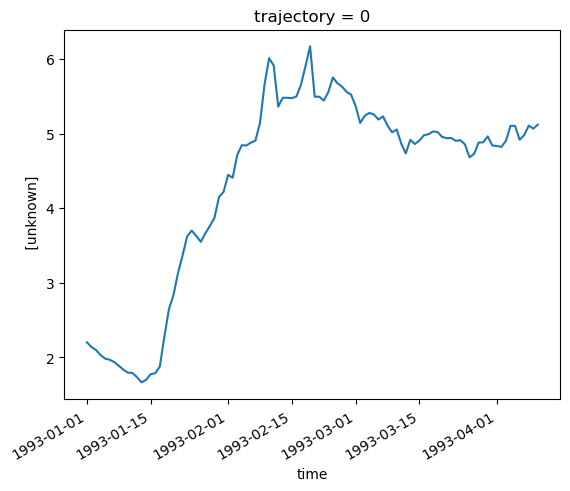

In [7]:
ds.isel(trajectory=0).temp.plot()
#ds.isel(trajectory=-1).temp.plot();

In [7]:
import seawater as gsw

def filter_beached_particles(ds,dim=None):
    """
    Filter particles in the dataset based on salinity.

    Parameters:
    ds (xarray.Dataset): The dataset containing salinity data.

    Returns:
    xarray.Dataset: A filtered dataset including only particles that have not reached zero salinity.
    """
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(particles_beached, drop=False)

    return ds_particles_reach_zero_salinity_beached

ds = filter_beached_particles(ds,'time')

def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

ds = compute_density(ds)

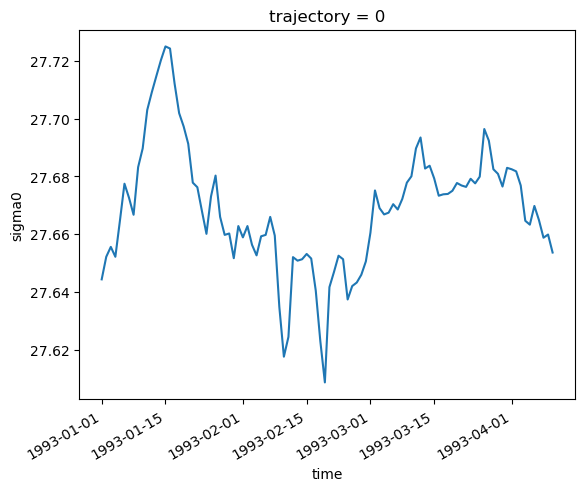

In [93]:
ds.isel(trajectory=0).sigma0.plot()

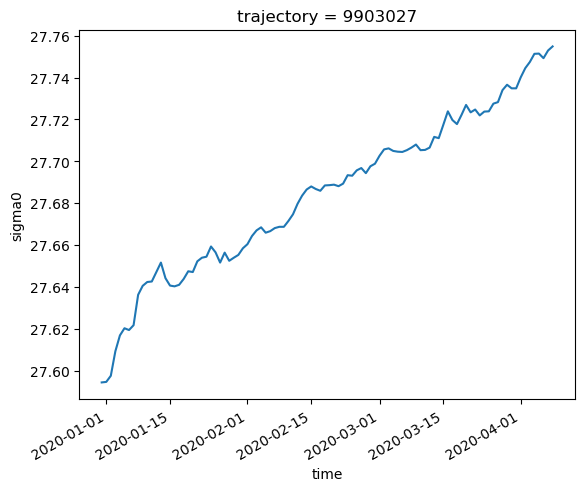

In [94]:
ds.isel(trajectory=-1).sigma0.plot()

In [95]:
ds.lat

<xarray.DataArray 'lat' (trajectory: 986500, time: 10013)>
dask.array<where, shape=(986500, 10013), dtype=float64, chunksize=(500, 600), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Attributes:
    axis:           Y
    long_name:      
    standard_name:  latitude
    units:          degrees_north

In [86]:
#full = xr.open_zarr('/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/iceland_expt/data2/level2/retry_with_time_parcels_releases_seed-123.zarr')

In [87]:
full.lat

<xarray.DataArray 'lat' (trajectory: 986500, time: 10013)>
dask.array<open_dataset-lat, shape=(986500, 10013), dtype=float64, chunksize=(500, 601), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Attributes:
    axis:           Y
    long_name:      
    standard_name:  latitude
    units:          degrees_north

In [ ]:
ds.lat

<xarray.DataArray 'lat' (trajectory: 986500, time: 10013)>
dask.array<where, shape=(986500, 10013), dtype=float64, chunksize=(500, 100), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-05-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Attributes:
    axis:           Y
    long_name:      
    standard_name:  latitude
    units:          degrees_north

In [106]:
ds_sel = ds.sel(time=pd.date_range("1993-01-01","2019-12-31", freq="5D"), method="nearest")


In [107]:
ds_sel

<xarray.Dataset>
Dimensions:     (trajectory: 986500, time: 1973)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-06 ... 2019-12-31
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027
Data variables:
    age         (trajectory, time) float32 dask.array<chunksize=(500, 120), meta=np.ndarray>
    lat         (trajectory, time) float64 dask.array<chunksize=(500, 120), meta=np.ndarray>
    lon         (trajectory, time) float64 dask.array<chunksize=(500, 120), meta=np.ndarray>
    salt        (trajectory, time) float32 dask.array<chunksize=(500, 120), meta=np.ndarray>
    temp        (trajectory, time) float32 dask.array<chunksize=(500, 120), meta=np.ndarray>
    uvel        (trajectory, time) float32 dask.array<chunksize=(500, 120), meta=np.ndarray>
    vvel        (trajectory, time) float32 dask.array<chunksize=(500, 120), meta=np.ndarray>
    z           (trajectory, time) float64 dask.array<chunksize=(500, 120), meta=np.ndarray>
    sigma0      (trajectory, time) float64 dask.array<chunksize=(500, 120), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [102]:
positions_w_var = {}

for i in tqdm.tqdm(ds_sel.time[:2]):
    positions_w_var[i.dt.strftime('%Y-%m-%d %H:%M:%S').item(0)] = {
        'lat': ds.lat.sel(time=i).values,
        'lon': ds.lon.sel(time=i).values,
        'z': ds.z.sel(time=i).values,
        'salt': ds.salt.sel(time=i).values,
        'temp': ds.temp.sel(time=i).values,
        'sigma0': ds.sigma0.sel(time=i).values
    }


  0%|          | 0/2 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [100]:
positions_w_var

{}

In [109]:
ds.lat.sel(time=ds_sel.time[0]).values

KeyboardInterrupt: 

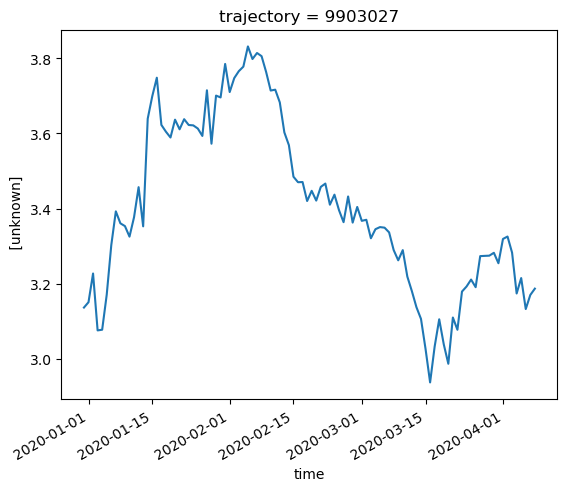

In [56]:
rechunked.isel(trajectory=-1).temp.plot()

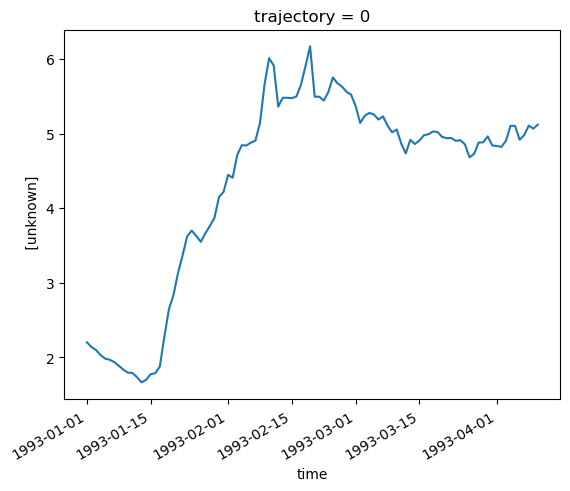

In [55]:
rechunked.isel(trajectory=0).temp.plot()

In [51]:
rechunked.to_zarr('data2/level3-2/AGAIN_slice_with_time_parcels_releases_seed-123.zarr', mode='w')

KeyboardInterrupt: 

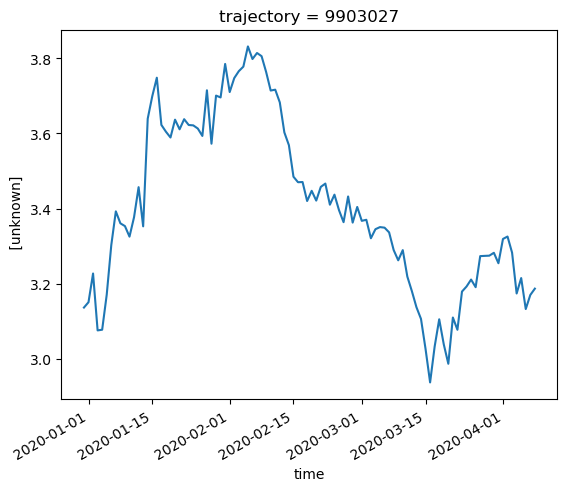

In [15]:
ds.isel(trajectory=-1).temp.plot();

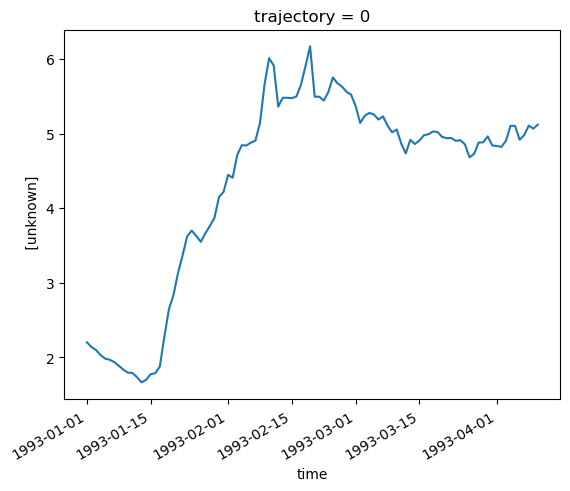

In [12]:
ds.isel(trajectory=0).temp.plot();

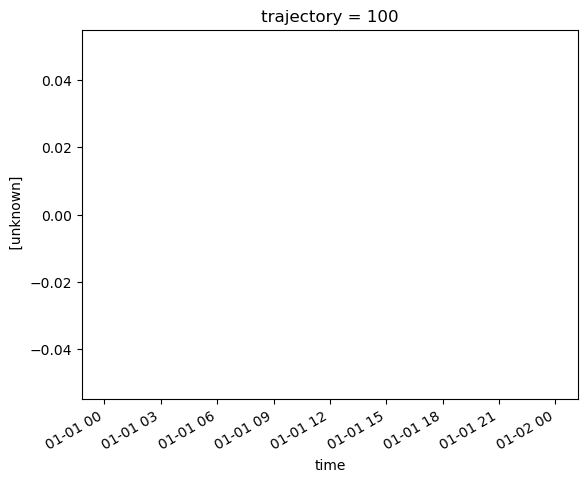

In [7]:
ds_w_time.isel(trajectory=100).temp.plot()

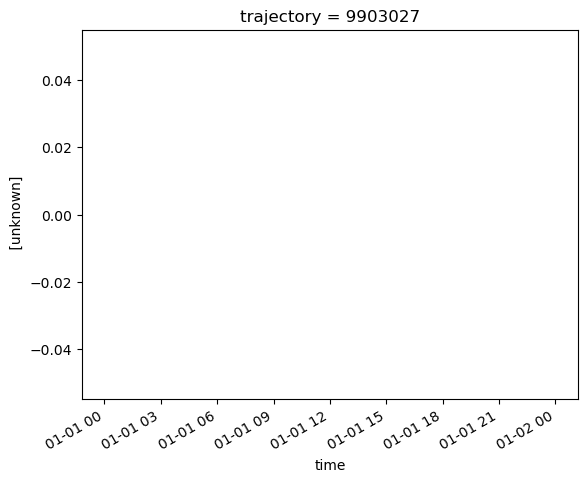

In [6]:
ds_w_time.isel(trajectory=-1).temp.plot()

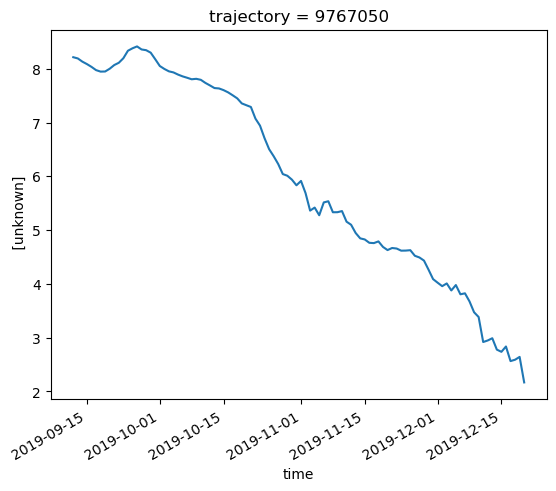

In [105]:
ds_w_time.isel(trajectory=975_000).temp.plot();

In [97]:
ds_w_time.trajectory

<xarray.DataArray 'trajectory' (trajectory: 986500)>
array([      0,       1,       2, ..., 9903025, 9903026, 9903027])
Coordinates:
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 9903024 9903025 9903026 9903027

In [23]:
def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

ds_w_time = compute_density(ds_w_time)

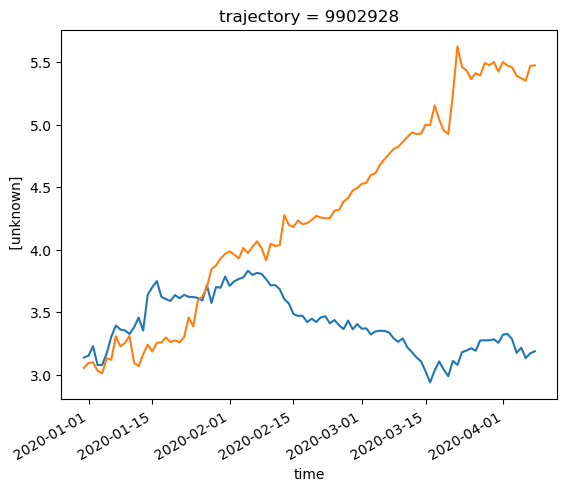

In [7]:
ds_w_time.isel(trajectory=-1).temp.dropna('time').isel(time=slice(0,100)).plot()
ds_w_time.isel(trajectory=-100).temp.dropna('time').isel(time=slice(0,100)).plot()
#ds_w_time.isel(trajectory=0).temp.dropna('time').isel(time=slice(0,100)).plot()

In [29]:
ds_w_time.isel(trajectory=-1).temp.dropna('time').isel(time=slice(0,100)).time

<xarray.DataArray 'time' (time: 100)>
array(['2019-12-31T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-01-04T00:00:00.000000000', '2020-01-05T00:00:00.000000000',
       '2020-01-06T00:00:00.000000000', '2020-01-07T00:00:00.000000000',
       '2020-01-08T00:00:00.000000000', '2020-01-09T00:00:00.000000000',
       '2020-01-10T00:00:00.000000000', '2020-01-11T00:00:00.000000000',
       '2020-01-12T00:00:00.000000000', '2020-01-13T00:00:00.000000000',
       '2020-01-14T00:00:00.000000000', '2020-01-15T00:00:00.000000000',
       '2020-01-16T00:00:00.000000000', '2020-01-17T00:00:00.000000000',
       '2020-01-18T00:00:00.000000000', '2020-01-19T00:00:00.000000000',
       '2020-01-20T00:00:00.000000000', '2020-01-21T00:00:00.000000000',
       '2020-01-22T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
       '2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
       '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
       '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-03T00:00:00.000000000', '2020-02-04T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-09T00:00:00.000000000', '2020-02-10T00:00:00.000000000',
       '2020-02-11T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-02-14T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-17T00:00:00.000000000', '2020-02-18T00:00:00.000000000',
       '2020-02-19T00:00:00.000000000', '2020-02-20T00:00:00.000000000',
       '2020-02-21T00:00:00.000000000', '2020-02-22T00:00:00.000000000',
       '2020-02-23T00:00:00.000000000', '2020-02-24T00:00:00.000000000',
       '2020-02-25T00:00:00.000000000', '2020-02-26T00:00:00.000000000',
       '2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-03-13T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-19T00:00:00.000000000',
       '2020-03-20T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-22T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
       '2020-03-24T00:00:00.000000000', '2020-03-25T00:00:00.000000000',
       '2020-03-26T00:00:00.000000000', '2020-03-27T00:00:00.000000000',
       '2020-03-28T00:00:00.000000000', '2020-03-29T00:00:00.000000000',
       '2020-03-30T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-04-02T00:00:00.000000000',
       '2020-04-03T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-05T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
       '2020-04-07T00:00:00.000000000', '2020-04-08T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-04-08
    trajectory  int64 9903027

In [24]:
ds_w_time_sel = ds_w_time.sel(time=pd.date_range("1993-01-01","2019-12-31", freq="1D"), method="nearest") # 1M


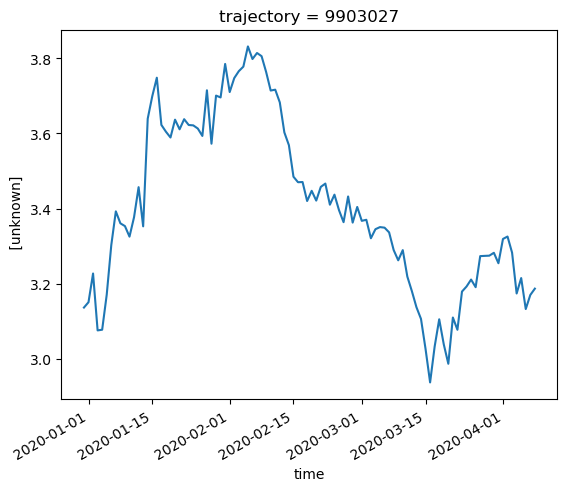

In [86]:
ds_w_time.isel(trajectory=-1).dropna(dim='time').isel(time=slice(0,100)).temp.plot()

In [98]:
# ds_w_time_dropna = ds_w_time.dropna(dim='time',how='all')

In [16]:
ds_select_only_weeks = []

# Loop through each trajectory
for i in tqdm.tqdm(np.arange(0, ds_w_time.trajectory.size, 100_000)):
    # Select the first 100 time indices for the current trajectory
    selected_data = ds_w_time.isel(trajectory=i).dropna(dim='time').isel(time=slice(0,100))
    ds_select_only_weeks.append(selected_data)

# Combine the selected data back into a single dataset
ds_select_only_weeks = xr.concat(ds_select_only_weeks, dim='trajectory')

100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


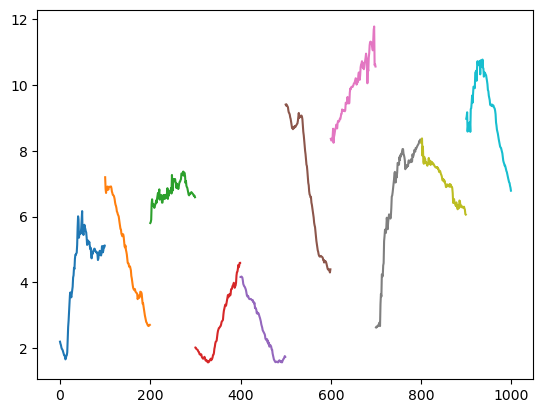

In [17]:
for i in range(ds_select_only_weeks.trajectory.size):
    plt.plot(ds_select_only_weeks.isel(trajectory=i).temp)
plt.show()

In [25]:
ds_select_only_weeks = []

# Loop through each trajectory
for i in tqdm.tqdm(np.arange(0, 10)):
    # Select the first 100 time indices for the current trajectory
    selected_data = ds_w_time.isel(trajectory=i).dropna(dim='time').isel(time=slice(0,100))
    ds_select_only_weeks.append(selected_data)

# Combine the selected data back into a single dataset
ds_select_only_weeks = xr.concat(ds_select_only_weeks, dim='trajectory')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [01:58<?, ?it/s]
Task exception was never retrieved
future: <Task finished name='Task-55461' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-55459' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait


KeyboardInterrupt: 

Task exception was never retrieved
future: <Task finished name='Task-55464' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-55454' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.

Task exception was never retrieved
future: <Task finished name='Task-55465' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
ds_select_only_weeks

In [ ]:

ds_sel = ds_select_only_weeks.sel(time=pd.date_range("1993-01-01","2019-12-31", freq="1D"), method="nearest")

print("Let's get cracking")

positions_w_var = {}

for i in tqdm.tqdm(ds_sel.time):
    positions_w_var[i.dt.strftime('%Y-%m-%d %H:%M:%S').item(0)] = {
        'lat': ds_select_only_weeks.lat.sel(time=i).values,
        'lon': ds_select_only_weeks.lon.sel(time=i).values,
        'z': ds_select_only_weeks.z.sel(time=i).values,
        'salt': ds_select_only_weeks.salt.sel(time=i).values,
        'temp': ds_select_only_weeks.temp.sel(time=i).values,
        'sigma0': ds_select_only_weeks.sigma0.sel(time=i).values
    }


Let's get cracking


  0%|          | 0/9861 [00:00<?, ?it/s]

  1%|          | 83/9861 [01:46<3:15:08,  1.20s/it]Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x149a2e60ce00>>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/utils_perf.py", line 176, in _gc_callback
    def _gc_callback(self, phase, info):

KeyboardInterrupt: 
  1%|          | 86/9861 [01:50<3:09:35,  1.16s/it]Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x149a2e60ce00>>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/utils_perf.py", line 183, in _gc_callback
    self._fractional_timer.start_timing()
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/utils_perf.py", line 118, in start_tim

In [12]:
ds_select_only_weeks = []

# Loop through each trajectory
for i in tqdm.tqdm(range(len(ds_w_time['trajectory'][:10]))):
    # Select the first 100 time indices for the current trajectory
    selected_data = ds_w_time.isel(trajectory=i).dropna(dim='time').isel(time=slice(0,100))
    ds_select_only_weeks.append(selected_data)

# Combine the selected data back into a single dataset
ds_select_only_weeks = xr.concat(ds_select_only_weeks, dim='trajectory')

  0%|          | 0/10 [00:10<?, ?it/s]
Task exception was never retrieved
future: <Task finished name='Task-10398' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-10391' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait


KeyboardInterrupt: 

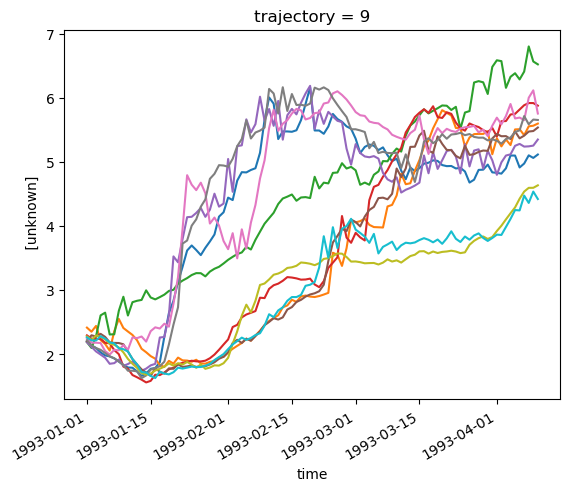

In [104]:
for i in range(10):
    ds_select_only_weeks.isel(trajectory=i).temp.plot()
plt.show()

In [106]:
ds_select_only_weeks.time

<xarray.DataArray 'time' (time: 100)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', '1993-01-04T00:00:00.000000000',
       '1993-01-05T00:00:00.000000000', '1993-01-06T00:00:00.000000000',
       '1993-01-07T00:00:00.000000000', '1993-01-08T00:00:00.000000000',
       '1993-01-09T00:00:00.000000000', '1993-01-10T00:00:00.000000000',
       '1993-01-11T00:00:00.000000000', '1993-01-12T00:00:00.000000000',
       '1993-01-13T00:00:00.000000000', '1993-01-14T00:00:00.000000000',
       '1993-01-15T00:00:00.000000000', '1993-01-16T00:00:00.000000000',
       '1993-01-17T00:00:00.000000000', '1993-01-18T00:00:00.000000000',
       '1993-01-19T00:00:00.000000000', '1993-01-20T00:00:00.000000000',
       '1993-01-21T00:00:00.000000000', '1993-01-22T00:00:00.000000000',
       '1993-01-23T00:00:00.000000000', '1993-01-24T00:00:00.000000000',
       '1993-01-25T00:00:00.000000000', '1993-01-26T00:00:00.000000000',
       '1993-01-27T00:00:00.000000000', '1993-01-28T00:00:00.000000000',
       '1993-01-29T00:00:00.000000000', '1993-01-30T00:00:00.000000000',
       '1993-01-31T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-02-02T00:00:00.000000000', '1993-02-03T00:00:00.000000000',
       '1993-02-04T00:00:00.000000000', '1993-02-05T00:00:00.000000000',
       '1993-02-06T00:00:00.000000000', '1993-02-07T00:00:00.000000000',
       '1993-02-08T00:00:00.000000000', '1993-02-09T00:00:00.000000000',
       '1993-02-10T00:00:00.000000000', '1993-02-11T00:00:00.000000000',
       '1993-02-12T00:00:00.000000000', '1993-02-13T00:00:00.000000000',
       '1993-02-14T00:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-02-16T00:00:00.000000000', '1993-02-17T00:00:00.000000000',
       '1993-02-18T00:00:00.000000000', '1993-02-19T00:00:00.000000000',
       '1993-02-20T00:00:00.000000000', '1993-02-21T00:00:00.000000000',
       '1993-02-22T00:00:00.000000000', '1993-02-23T00:00:00.000000000',
       '1993-02-24T00:00:00.000000000', '1993-02-25T00:00:00.000000000',
       '1993-02-26T00:00:00.000000000', '1993-02-27T00:00:00.000000000',
       '1993-02-28T00:00:00.000000000', '1993-03-01T00:00:00.000000000',
       '1993-03-02T00:00:00.000000000', '1993-03-03T00:00:00.000000000',
       '1993-03-04T00:00:00.000000000', '1993-03-05T00:00:00.000000000',
       '1993-03-06T00:00:00.000000000', '1993-03-07T00:00:00.000000000',
       '1993-03-08T00:00:00.000000000', '1993-03-09T00:00:00.000000000',
       '1993-03-10T00:00:00.000000000', '1993-03-11T00:00:00.000000000',
       '1993-03-12T00:00:00.000000000', '1993-03-13T00:00:00.000000000',
       '1993-03-14T00:00:00.000000000', '1993-03-15T00:00:00.000000000',
       '1993-03-16T00:00:00.000000000', '1993-03-17T00:00:00.000000000',
       '1993-03-18T00:00:00.000000000', '1993-03-19T00:00:00.000000000',
       '1993-03-20T00:00:00.000000000', '1993-03-21T00:00:00.000000000',
       '1993-03-22T00:00:00.000000000', '1993-03-23T00:00:00.000000000',
       '1993-03-24T00:00:00.000000000', '1993-03-25T00:00:00.000000000',
       '1993-03-26T00:00:00.000000000', '1993-03-27T00:00:00.000000000',
       '1993-03-28T00:00:00.000000000', '1993-03-29T00:00:00.000000000',
       '1993-03-30T00:00:00.000000000', '1993-03-31T00:00:00.000000000',
       '1993-04-01T00:00:00.000000000', '1993-04-02T00:00:00.000000000',
       '1993-04-03T00:00:00.000000000', '1993-04-04T00:00:00.000000000',
       '1993-04-05T00:00:00.000000000', '1993-04-06T00:00:00.000000000',
       '1993-04-07T00:00:00.000000000', '1993-04-08T00:00:00.000000000',
       '1993-04-09T00:00:00.000000000', '1993-04-10T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-04-10

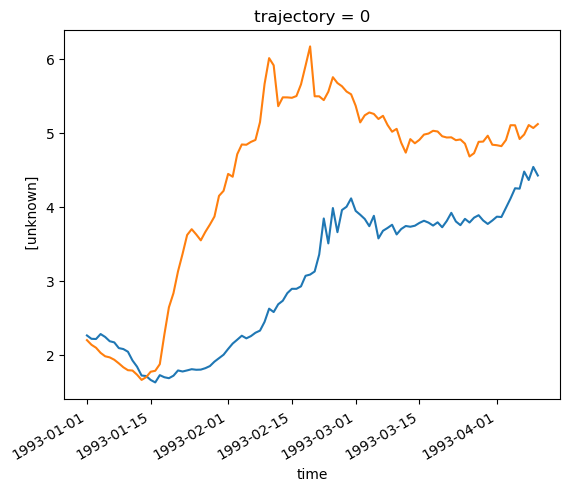

In [81]:
ds_select_only_weeks.isel(trajectory=-1).temp.plot()
ds_select_only_weeks.isel(trajectory=0).temp.plot()

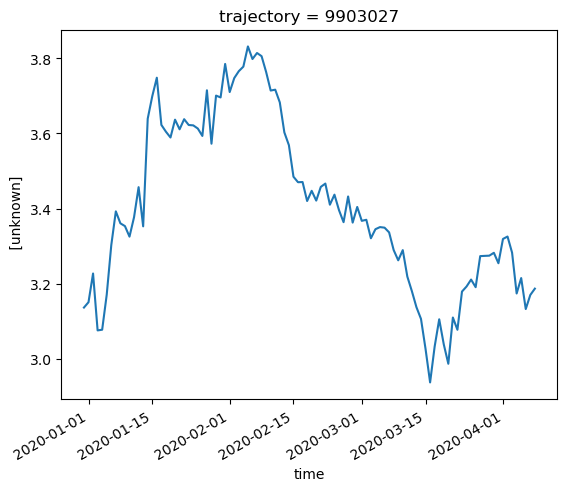

In [82]:
ds_select_only_weeks = []

# Get the total number of trajectories
num_trajectories = len(ds_w_time['trajectory'])

# Loop through the last 100 trajectories
for i in range(num_trajectories - 100, num_trajectories):
    # Select the first 100 time indices for the current trajectory
    selected_data = ds_w_time.isel(trajectory=i).dropna(dim='time').isel(time=slice(0,100))
    ds_select_only_weeks.append(selected_data)

# Combine the selected data back into a single dataset
ds_select_only_weeks = xr.concat(ds_select_only_weeks, dim='trajectory')


KeyboardInterrupt: 

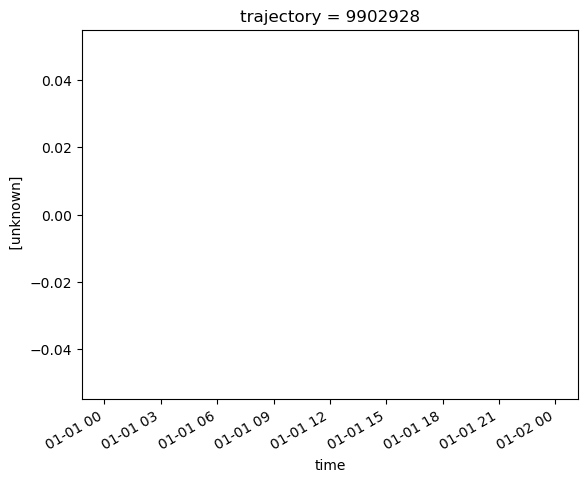

In [53]:
ds_select_only_weeks.isel(trajectory=-1).temp.plot()
ds_select_only_weeks.isel(trajectory=0).temp.plot()

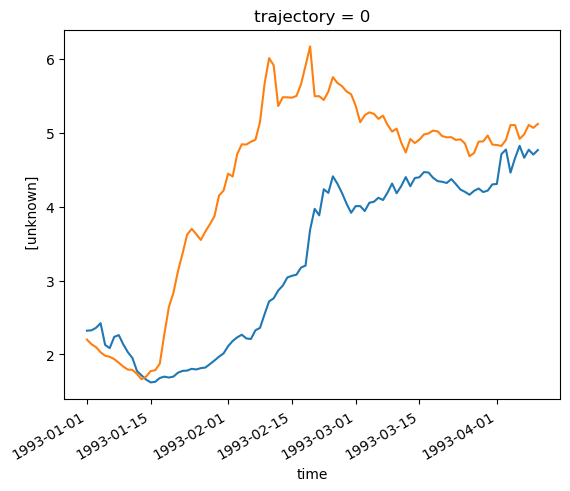

In [47]:
ds_select_only_weeks.isel(trajectory=-1).temp.plot()
ds_select_only_weeks.isel(trajectory=0).temp.plot()

In [50]:
ds_select_only_weeks.isel(trajectory=-1)

<xarray.Dataset>
Dimensions:     (time: 100)
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1993-04-10
    trajectory  int64 499
Data variables:
    age         (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    lat         (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    lon         (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    salt        (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    temp        (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    uvel        (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    vvel        (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    z           (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    sigma0      (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

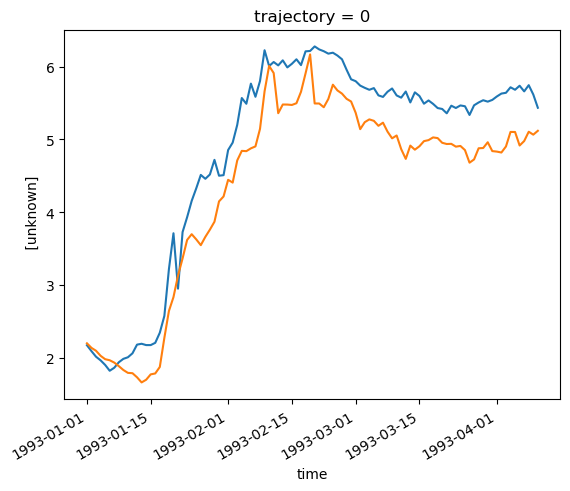

In [49]:
ds_select_only_weeks.isel(trajectory=-1).temp.plot()
ds_select_only_weeks.isel(trajectory=0).temp.plot()

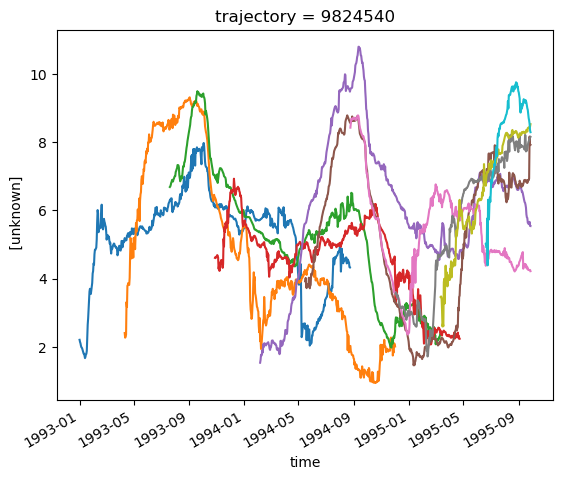

In [25]:
for i in np.arange(0, ds_w_time_sel.trajectory.size, 10_000):
    ds_w_time.isel(trajectory=i).temp.isel(time=slice(0,1000)).plot()
plt.show()

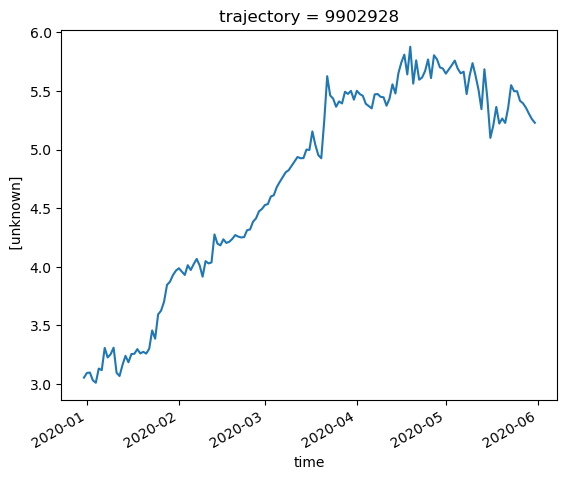

In [31]:
ds_w_time.isel(trajectory=-100).temp.plot();

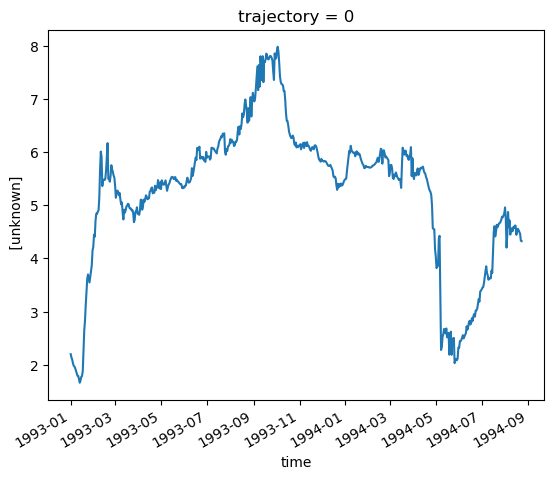

In [32]:
ds_w_time.isel(trajectory=0).temp.plot();

In [33]:

def extract_positions_with_variables(ds_sel, ds):
    positions_w_var = {}

    for i in tqdm.tqdm(ds_sel.time):
        positions_w_var[i.dt.strftime('%Y-%m-%d %H:%M:%S').item(0)] = {
            'lat': ds.lat.sel(time=i).values,
            'lon': ds.lon.sel(time=i).values,
            'z': ds.z.sel(time=i).values,
            'salt': ds.salt.sel(time=i).values,
            'temp': ds.temp.sel(time=i).values,
            'sigma0': ds.sigma0.sel(time=i).values
        }
    
    return positions_w_var



def save_positions_to_parquet(positions_w_var, filename):
    """
    Save the positions with variables to a Parquet file.

    Parameters: 
    positions_w_var (dict): Dictionary containing positions with variables.
    filename (str): The name of the file to save the Parquet data.
    """
    # Convert the dictionary to a DataFrame, transpose it, and save as Parquet
    pd.DataFrame(positions_w_var).T.to_parquet(filename)

# Usage example
# save_positions_to_parquet(positions_w_var, 'positions__S_T_monthly_all.parq')
 

In [34]:
pos = extract_positions_with_variables(ds_w_time_sel, ds_w_time)

100%|██████████| 324/324 [1:29:23<00:00, 16.55s/it]


In [35]:
save_positions_to_parquet(pos, 'iceland_positions_monthly.parq')

In [39]:
df = pd.read_parquet('iceland_positions_monthly.parq')
timerange = pd.date_range("1993-01-01","2019-12-31", freq="1M")

In [40]:
sample_size = 12_000 # Adjust this number to control the density
sampled_indices = np.random.choice(len(df.lon[-1]), sample_size, replace=False)


In [45]:
# df

In [ ]:
## TEMPERATURE 

for i in range(1, 5):  # Adjust the range as needed
    # Create a new figure for each iteration
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 15, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
                                transform=ccrs.PlateCarree(), cmap='binary')
    
    # Scatter plot for the current frame
    x = ax.scatter(df.lon[i][sampled_indices], df.lat[i][sampled_indices], 
                   s=2, c=df.temp[i][sampled_indices], vmin=1, vmax=10., 
                   cmap='RdBu_r', transform=ccrs.PlateCarree())
    
    ax.set_title(timerange[i].strftime('%Y-%m-%d'))
    ax.coastlines()
    
    # Set up gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Plot a line on the map
    #ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
    ax.plot([-7,-12],[65,65],color='k', transform=ccrs.PlateCarree())
    # Add colorbar
    cbar = plt.colorbar(x)
    cbar.set_label('Temperature ($^circ$C)')
    plt.tight_layout()
    plt.close()


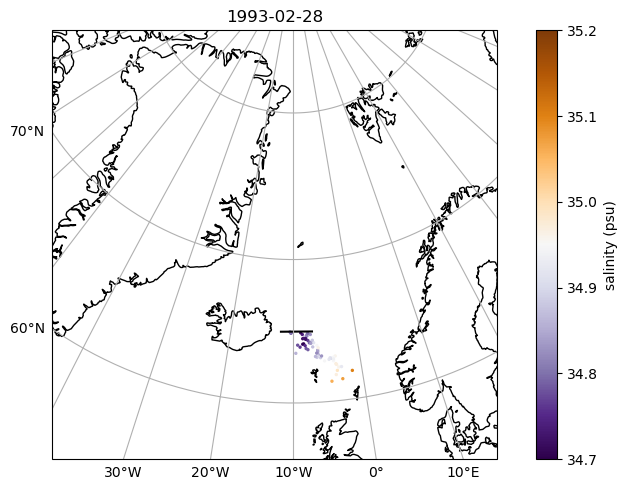

In [64]:
## SALINITY

for i in range(1, 2):  # Adjust the range as needed
    # Create a new figure for each iteration
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 15, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
                                transform=ccrs.PlateCarree(), cmap='binary')
    
    # Scatter plot for the current frame
    x = ax.scatter(df.lon[i][sampled_indices], df.lat[i][sampled_indices], 
                   s=2, c=df.salt[i][sampled_indices], vmin=34.7,vmax=35.2,
                   cmap='PuOr_r', transform=ccrs.PlateCarree())
    
    ax.set_title(timerange[i].strftime('%Y-%m-%d'))
    ax.coastlines()
    
    # Set up gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Plot a line on the map
    #ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
    ax.plot([-7,-12],[65,65],color='k', transform=ccrs.PlateCarree())
    # Add colorbar
    cbar = plt.colorbar(x)
    cbar.set_label('salinity (psu)')
    plt.tight_layout()
    plt.show()


In [ ]:
## TEMPERATURE IMAGES

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import imageio
import os

# List to store filenames for the GIF
filenames = []

# Loop through the range of indices
for i in range(1, len(df.lat)):  # Adjust the range as needed
    # Create a new figure for each iteration
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 15, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
                                transform=ccrs.PlateCarree(), cmap='binary')
    
    # Scatter plot for the current frame
    x = ax.scatter(df.lon[i][sampled_indices], df.lat[i][sampled_indices], 
                   s=2, c=df.temp[i][sampled_indices], vmin=1, vmax=10., 
                   cmap='RdBu_r', transform=ccrs.PlateCarree())
    
    ax.set_title(timerange[i].strftime('%Y-%m-%d'))
    ax.coastlines()
    
    # Set up gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Plot a line on the map
    ax.plot([-7,-12],[65,65],color='k', transform=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(x)
    cbar.set_label(r'temperature ($^\circ$C)')
    plt.tight_layout()
    
    # Save the figure as a PNG file
    filename = f'imgs/temp/frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)  # Store the filename for later use
    
    # Close the figure to free up memory
    plt.close(fig)

# # Create a GIF from the saved images
# with imageio.get_writer('imgs/output_loop_salinity.gif', mode='I', duration=1, loop=0) as writer:  # loop=0 means infinite loop
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Optionally, you can remove the PNG files after creating the GIF
# for filename in filenames:
#     os.remove(filename)


In [65]:
## SALINITY IMAGES 

# List to store filenames for the GIF
filenames = []

# Loop through the range of indices
for i in range(1, len(df.lat)):  # Adjust the range as needed
    # Create a new figure for each iteration
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 15, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
                                transform=ccrs.PlateCarree(), cmap='binary')
    
    # Scatter plot for the current frame
    x = ax.scatter(df.lon[i][sampled_indices], df.lat[i][sampled_indices], 
                   s=2, c=df.salt[i][sampled_indices],vmin=34.7,vmax=35.2, 
                   cmap='PuOr_r', transform=ccrs.PlateCarree())
    
    ax.set_title(timerange[i].strftime('%Y-%m-%d'))
    ax.coastlines()
    
    # Set up gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Plot a line on the map
    ax.plot([-7,-12],[65,65],color='k', transform=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(x)
    cbar.set_label('salinity (psu)')
    plt.tight_layout()
    
    # Save the figure as a PNG file
    filename = f'imgs/salt/frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)  # Store the filename for later use
    
    # Close the figure to free up memory
    plt.close(fig)

# # Create a GIF from the saved images
# with imageio.get_writer('imgs/output_loop_salinity.gif', mode='I', duration=1, loop=0) as writer:  # loop=0 means infinite loop
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Optionally, you can remove the PNG files after creating the GIF
# for filename in filenames:
#     os.remove(filename)


In [67]:
import imageio
import glob

# Path to the directory containing images
image_folder = 'imgs/temp/'  # Replace with your image folder path

file_pattern = os.path.join(image_folder, 'frame_*.png')  # Adjust the pattern as needed
filenames = sorted(glob.glob(file_pattern), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
# Specify the output MP4 file path
output_file = 'temp_movie.mp4'

# Create a video writer object
with imageio.get_writer(output_file, fps=5, quality=8) as writer:  # Adjust fps as needed
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video saved as {output_file}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 500) to (800, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as temp_movie.mp4


In [68]:

# Path to the directory containing images
image_folder = 'imgs/salt/'  # Replace with your image folder path

file_pattern = os.path.join(image_folder, 'frame_*.png')  # Adjust the pattern as needed
filenames = sorted(glob.glob(file_pattern), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
# Specify the output MP4 file path
output_file = 'salinity_movie.mp4'

# Create a video writer object
with imageio.get_writer(output_file, fps=5, quality=8) as writer:  # Adjust fps as needed
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video saved as {output_file}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 500) to (800, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as salinity_movie.mp4


In [53]:
# image_folder = 'imgs/temp/'  # Replace with your image folder path

# file_pattern = os.path.join(image_folder, 'frame_*.png')  # Adjust the pattern as needed
# filenames = sorted(glob.glob(file_pattern), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

# # Specify the output MP4 file path
# output_file = 'temp_movie.mp4'

# # Create a video writer object
# fps = 30  # Increase the frame rate for smoother playback
# with imageio.get_writer(output_file, fps=fps, quality=8) as writer:  # Adjust quality as needed
#     for i in range(len(filenames)):
#         image = imageio.imread(filenames[i])
#         writer.append_data(image)
        
#         # Add cross-dissolve effect with the next frame
#         if i < len(filenames) - 1:
#             next_image = imageio.imread(filenames[i + 1])
#             for alpha in np.linspace(0, 1, num=5):  # 5 frames for the transition
#                 blended_image = (1 - alpha) * image + alpha * next_image
#                 writer.append_data(blended_image.astype(np.uint8))

# print(f"Video saved as {output_file}")

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:16<00:00, 11.94it/s]


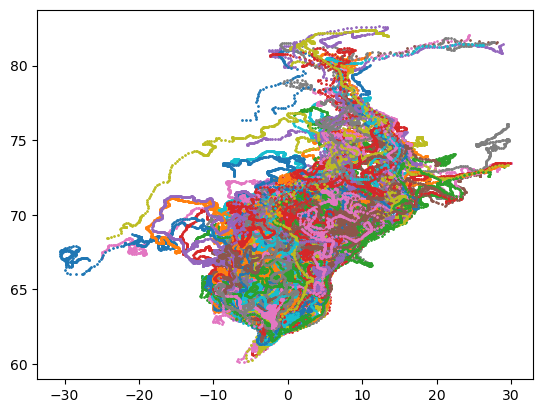

In [6]:
for i in tqdm.tqdm(np.arange(0,ds.trajectory.size,5_000)):
    plt.scatter(ds.lon.isel(trajectory=i),ds.lat.isel(trajectory=i),s=1)
plt.show()

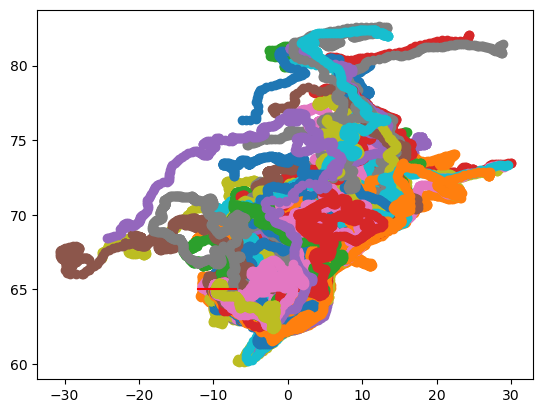

In [8]:
for i in np.arange(0,ds.trajectory.size,10_000):
    plt.scatter(ds.lon.isel(trajectory=i),ds.lat.isel(trajectory=i),cmap='viridis')
plt.plot([-7, -12], [65, 65],color='red')
plt.show()

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

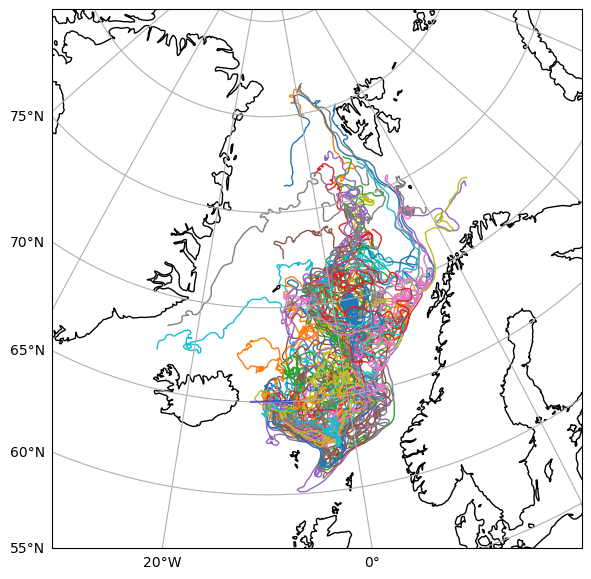

In [14]:
import matplotlib.colors as mcolors
# Assuming mesh_mask, speed_m, lon_ds_filter, and lat_ds_filter are already defined

# Create a figure with an orthographic projection
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-30, 20, 55, 85], crs=ccrs.PlateCarree())

# Loop through the trajectories and plot them
i = np.arange(0, ds.trajectory.size, 20_000) #np.arange(ds_filter.trajectory.size) #
colors = list(mcolors.TABLEAU_COLORS.values())
for idx, index in enumerate(i):
    print(idx,end='')
    # Use plt.plot to connect the points with a line
    ax.plot(
        ds.lon.isel(trajectory=index), 
        ds.lat.isel(trajectory=index), 
        color=colors[idx % len(colors)], 
        linewidth=1,  # Adjust the line width here
        transform=ccrs.PlateCarree()
    )
plt.plot([-7,-12],[65,65],color='blue', transform=ccrs.PlateCarree())
# Add coastlines
ax.coastlines()
# Add gridlines for longitude and latitude
gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#plt.savefig('particle_release',dpi=600,bbox_inches='tight',transparent=False)
plt.show()


In [9]:
def calc_min_max(ds):
    lon_min = float(ds.lon.min().values)
    lon_max = float(ds.lon.max().values)
    lat_min = float(ds.lat.min().values)
    lat_max = float(ds.lat.max().values)
    res = {'lon_min': lon_min, 'lon_max': lon_max,
           'lat_min': lat_min, 'lat_max': lat_max}
    return res

min_lon_lat_max = calc_min_max(ds)

n=0.25
lon_bins = np.arange(min_lon_lat_max['lon_min'], min_lon_lat_max['lon_max'], n)
lat_bins = np.arange(min_lon_lat_max['lat_min'], min_lon_lat_max['lat_max'], n)

In [10]:
def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'obs': -1})

lon_rechunk = rechunk_for_hist(ds['lon'])
lat_rechunk = rechunk_for_hist(ds['lat'])

In [11]:

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days

In [12]:
heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'],
    bin_dim_suffix="") #dim=['obs'],

heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], #, dim=['trajectory'], # with dim=trajectory, the  chunks were way too big over 5 Gib
    bin_dim_suffix="")

In [13]:
# Summing particle counts over the whole integration period
heat_map_obs_sum = heat_map_traj#.sum(dim='obs')

# Dividing by the total number of particle counts for all bins
total_counts = heat_map_obs_sum.sum()
heat_map_normalized = heat_map_obs_sum / total_counts

In [14]:
# Calculate the total number of observations
total_observations = ds.time.size

# Calculate the probability for each bin
heat_map_probability_obs = (heat_map_obs / total_observations) * 100


In [15]:
# Summing particle counts over the whole integration period, considering each particle only once per bin
heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# Dividing by the total number of particles to get the probability for each bin
total_particles = ds.trajectory.size
heat_map_probability = (heat_map_obs_unique / total_particles) * 100

In [16]:
#rechunked = heat_map_normalized.chunk({'lat': 100, 'lon': 100})

# Compute the result
heat_map_normalized_comp = heat_map_normalized.compute()

heat_map_compute = heat_map_obs.sum(dim='trajectory').compute()

heat_map_probability_compute = heat_map_probability.compute()

In [17]:
lon,lat = heat_map_probability_obs.lon,heat_map_probability_obs.lat

In [18]:
def plot_particle_maps(ds_binned, cmap, cbar_label, vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-30, 20, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')
    
    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(ds_binned)
    if vmax is None:
        vmax = np.max(ds_binned)

    # Plot the particle density
    x = ax.pcolormesh(lon, lat, ds_binned, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(x)
    cbar.set_label(cbar_label)
    
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    ax.plot([-7, -12], [65, 65], color='red', transform=ccrs.PlateCarree())
    plt.show()

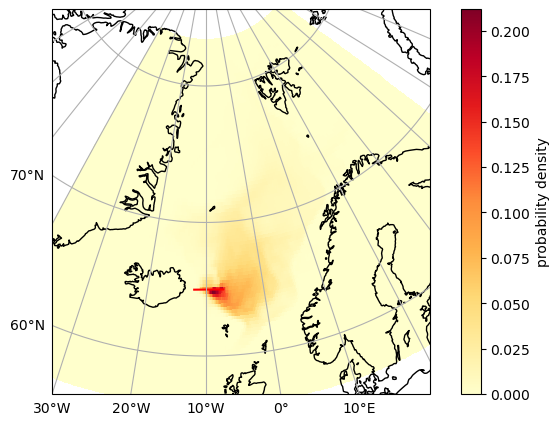

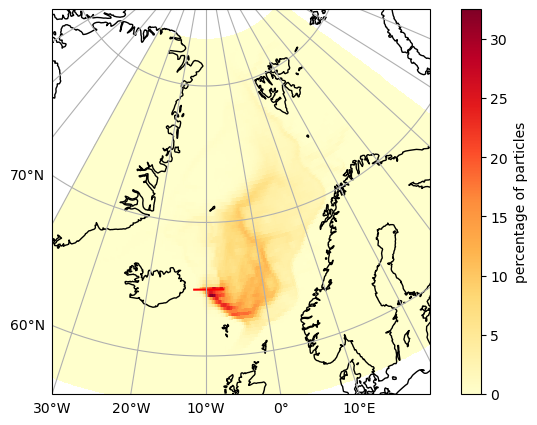

In [19]:
plot_particle_maps(heat_map_normalized_comp*100, 'YlOrRd','probability density')
plot_particle_maps(heat_map_probability_compute,'YlOrRd','percentage of particles') 

In [23]:
np.log10(heat_map_probability_compute).max()

<xarray.DataArray 'histogram_lat_lon' ()>
array(1.51203572)

In [34]:
np.log10(heat_map_normalized_comp).max()

<xarray.DataArray 'histogram_lat_lon' ()>
array(-2.67383722)

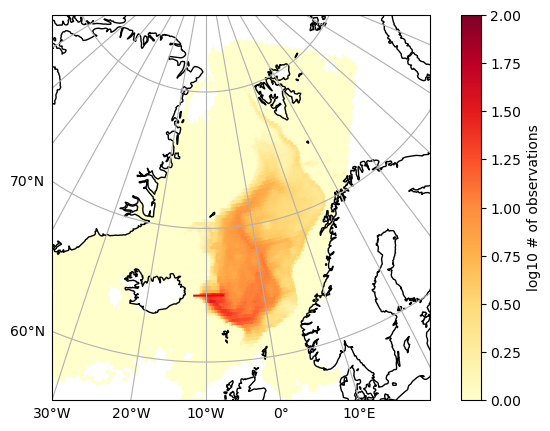

In [38]:
plot_particle_maps(np.log10(heat_map_probability_compute),'YlOrRd','log10 # of observations',vmin=0,vmax=2) 
#plot_particle_maps(np.log10(heat_map_normalized_comp),'YlOrRd','log10 # of observations',vmin=-.5,vmax=0) 

In [41]:
mask_0_probability = xr.where(100*heat_map_normalized_comp>0.001,1, np.nan)
mask_0_probability = mask_0_probability.rename({'lat':'lat_bin','lon':'lon_bin'})

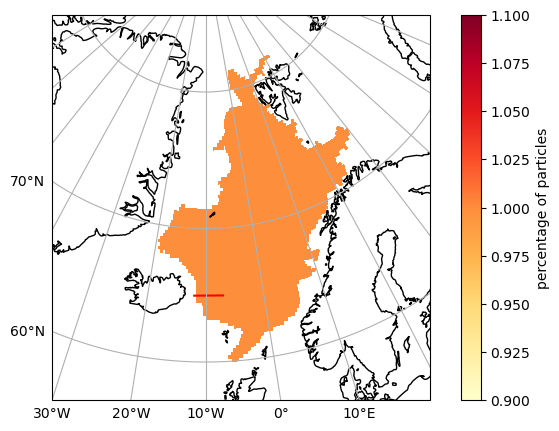

In [42]:
plot_particle_maps(mask_0_probability,'YlOrRd','percentage of particles') 

In [43]:
def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp

In [44]:
mean_salt = get_mean_maps(ds.salt,lon_rechunk,lat_rechunk)
mean_age = get_mean_maps(ds.age,lon_rechunk,lat_rechunk)
mean_temp = get_mean_maps(ds.temp,lon_rechunk,lat_rechunk)

In [45]:
%%time 

mean_age_cp = mean_age.compute()
mean_salt_cp = mean_salt.compute()
mean_temp_cp = mean_temp.compute()

CPU times: user 6min 54s, sys: 1min 2s, total: 7min 57s
Wall time: 4min 6s


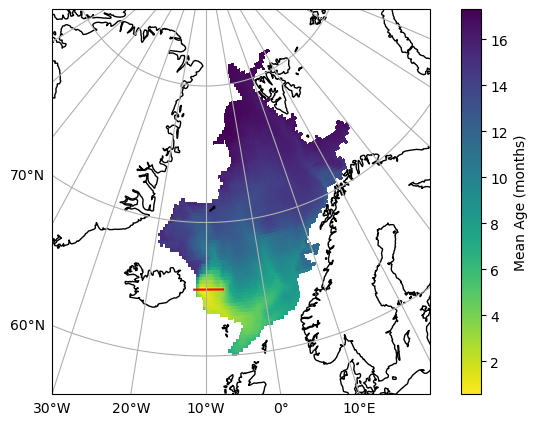

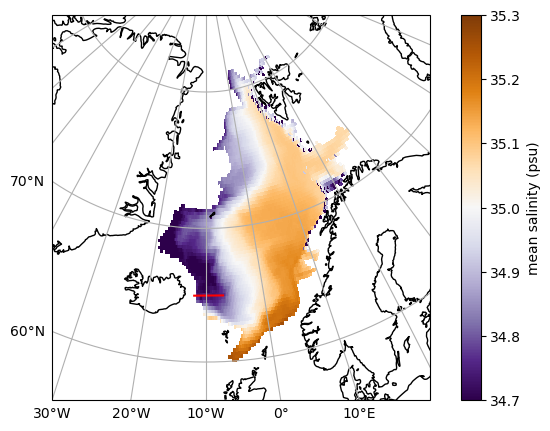

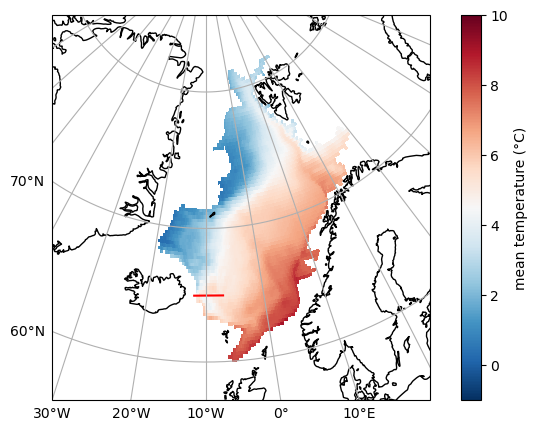

In [60]:
plot_particle_maps(mean_age_cp.T*hours_to_months*mask_0_probability, 'viridis_r', 'Mean Age (months)')
plot_particle_maps(mean_salt_cp.T*mask_0_probability, 'PuOr_r', 'mean salinity (psu)',vmin=34.7, vmax=35.3)
plot_particle_maps(mean_temp_cp.T*mask_0_probability, 'RdBu_r', 'mean temperature (°C)',vmin=-1,vmax=10)